Figure 2D

By Harshaan Sekhon (sskhon2014@berkeley.edu)

Files Explained: 

1. **hg38.phyloP100way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP100way/.
2. **hg38.phyloP20way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP20way/.
3. **hg38.phyloP20way.bw** was downloaded from http://hgdownload.cse.ucsc.edu/goldenpath/hg38/phyloP7way/.



4. **all_eclip_peaks.txt**: ENCORE eCLIP Peak Sets were downloaded as TXT files, in the BED format. In a directory containing all TXT files, the following command line prompt was used to generate a single file: <code> cat * > all_eclip_peaks.csv </code>. The ENCORE project has provided eCLIP peak sets (called by the algorithm CLIPper.) for the following  samples on GEO: GSM2424020, GSM2423898, GSM2423163, GSM2423828, GSM2423628, GSM2424038, GSM2424172, GSM2424114, GSM2424262, GSM2423694, GSM2424161, GSM2424183, GSM2423620, GSM2423807, GSM2424043, GSM2423297, GSM2424104, GSM2422882, GSM2424102, GSM2423325, GSM2424240, GSM2423957, GSM2423193, GSM2423213, GSM2423285, GSM2423796, GSM2423906, GSM2423711, GSM2423097, GSM2423241, GSM2423451, GSM2423602, GSM2423691, GSM2424216 , GSM2422944, GSM2423480, GSM2423763, GSM2423478, GSM2424110, GSM2423509, GSM2424212, GSM2422904, GSM2423289, GSM2423152, GSM2423550,  GSM2424058, GSM2424074, GSM2422967, GSM2423143, GSM2423630, GSM2424223, GSM2423824, GSM2423270, GSM2423381, GSM2423925, GSM2423137, GSM2423274, GSM2423562, GSM2423306, GSM2423243,  GSM2424180, GSM2422937, GSM2423049, GSM2423071, GSM2423237, GSM2423548, GSM2422873, GSM2423821, GSM2423064, GSM2423475, GSM2423524, GSM2423683, GSM2423707, GSM2423584, GSM2422935, GSM2423379, GSM2423634, GSM2424062, GSM2424118, GSM2423357, GSM2423505, GSM2423222, GSM2423815, GSM2423618, GSM2424076, GSM2423817, GSM2423826. 



5. **Peak sets other than those for GCLiPP**: For all of the techniques below, first, raw sequencing reads were downloaded from the internet. Then these raw sequencing reads had were run through FastQC 0.11.9 to determine their adaptors. Then, adaptors were removed from the reads using cutadapt version 1.7.1. Then, the Cutadapt-removed sequencing reads were aligned to the GRCh38 genome assembly using bowtie2. Lastly, CLIPper 2.0 was called on this aligned sequencing file (in BAM format) to establish a list of genomic loci where each technique shows enrichment. In all instances in this paper where CLIPper 2.0 was run, it was run on completely default settings. The source of each method’s sequencing reads is stated below:

    - OOPS – Raw sequencing reads were downloaded from the European Nucleotide Archive (ENA) (https://www.ebi.ac.uk/ena/browser/view/PRJEB26736). For the 150 mJ/cm2 run, the following run accession codes label the 4 replicates within the ENA: SAMEA4663545, SAMEA4663546, SAMEA4663547, SAMEA4663548.  Raw sequencing reads were downloaded from these runs and merged into one fastq file. Then,  this fastq file was processed as stated above. For the 275 mJ/cm2 run, the following accession codes label the 4 replicates: ERR2580521, ERR2580522, ERR2580523, ERR2580524. Raw sequencing reads were downloaded from these runs and merged into one fastq file. Then,  this fastq file was processed as stated above. The resultant file used in this analysis is **275_sorted_de_dup.bed**.

    - XRNAX – Raw sequencing reads were downloaded for two conditions: (1) XRNAX w/ ribosomal RNA depleted (ERR2537872), and (2) XRNAX w/ all RNA (ERR2537875). Then,  these fastq files were separately processed as stated above. The resultant file used in this analysis is **ERR2537872_10t_sorted_picard_clipper_2.0.bed**


6. **GCLiPP_clipper_2.bed**: This file is the output from an execution of the Clipper 2.0 peak colling algoritm upon a GCLiPP experimental dataset of both stimulated and unstimulated Jurkat T Cells pooled together.

In [1]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import pyBigWig
import math

In [2]:
def get_phylop(datum):
    datum = np.asarray(datum).T
    chroms = list(datum[0])
    starts= list(datum[1])
    stops= list(datum[2])
    strands= list(datum[3])
    centers = np.asarray([int(i) for i in (np.asarray(starts) + np.asarray(stops))/2])
    starts = list(centers - 100)
    stops = list(centers + 100)
    bw = pyBigWig.open(filename)
    size = len(chroms)
    b = np.asarray([0.0 for x in bw.values(chroms[0], int(starts[0])-1, int(stops[0]))])
    all_phylop = b
    count_fails = 0
    if show_tqdm:
        pbar = tqdm.tqdm(total=size)
    for i in np.arange(size):
        if show_tqdm:
            pbar.update(1)
        chrom = chroms[i]
        start = starts[i]
        stop = stops[i]
        strand = strands[i]
        try:
            a = [0.0 if math.isnan(x) else x for x in bw.values(chrom, start-1, stop)]

            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            b = a + b
            a = [0 if math.isnan(x) else 1 for x in bw.values(chrom, start-1, stop)]
            if strand == "-":
                a.reverse()
            a = np.asarray(a)
            all_phylop = all_phylop + a
        except RuntimeError:
            count_fails = count_fails + 1

    all_phylop = np.asarray(all_phylop)
    y,all_phylop_lstm = np.asarray([i/j for i,j in zip(b, all_phylop)]),all_phylop
    print("Fails: " + str(count_fails))
    return y#, phyloP_list

def multi_p(data):
    import time
    import multiprocessing
    from multiprocessing import Pool
    import tqdm
    import psutil
    start_time = time.time()
    cpu_cores = psutil.cpu_count(logical = True)
    with Pool(processes=cpu_cores,maxtasksperchild=50) as pool:
        lists = pool.map(get_phylop, np.array_split(data,cpu_cores))
    stop_time = time.time()


    pool.close()
    pool.join()
    print('Total Runtime: ' + str(round(stop_time-start_time,2)) + ' seconds')
    return sum(lists)/len(lists)

def normalize(arr):
    arr = (arr - np.mean(arr))/np.std(arr)
    return arr

In [3]:
gclipp = pd.read_csv('Resources/Clipper_Peaks/GCLiPP_clipper_2.bed', sep="\t", header=None)
gclipp.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
gclipp = (gclipp[['chrom','start','stop','strands']])
gclipp = gclipp.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
gclipp_p100 = multi_p(gclipp)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
gclipp_p20 = multi_p(gclipp)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
gclipp_p7 = multi_p(gclipp)

del gclipp

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 2
Total Runtime: 9.67 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 2
Total Runtime: 8.95 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 2
Fails: 0
Fails: 0
Total Runtime: 8.1 seconds


In [4]:
xrnax = pd.read_csv('Resources/Clipper_Peaks/ERR2537872_10t_sorted_picard_clipper_2.0.bed', sep="\t", header=None)
xrnax.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
xrnax = (xrnax[['chrom','start','stop','strands']])
xrnax = xrnax.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
xrnax_p100 = multi_p(xrnax)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
xrnax_p20 = multi_p(xrnax)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
xrnax_p7 = multi_p(xrnax)

del xrnax

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 10.3 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 9.8 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 9.04 seconds


In [5]:
oops = pd.read_csv('Resources/Clipper_Peaks/275_sorted_de_dup.bed', sep="\t", header=None)
oops.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3"]
oops = (oops[['chrom','start','stop','strands']])
oops = oops.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
oops_p100 = multi_p(oops)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
oops_p20 = multi_p(oops)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
oops_p7 = multi_p(oops)

del oops

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0Fails: 0

Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.53 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0Fails: 0

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.43 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 1.21 seconds


In [6]:
eclip = pd.read_csv('Resources/Clipper_Peaks/all_eclip_peaks.txt', sep="\t", header=None)
eclip.columns = ["chrom", "start", "stop","id", "v1", "strands", "v2", "v3", "v4", "v5"]
eclip = (eclip[['chrom','start','stop','strands']])
eclip = eclip.to_numpy()

filename,show_tqdm="Resources/hg38.phyloP100way.bw",False
eclip_p100 = multi_p(eclip)

filename,show_tqdm="Resources/hg38.phyloP20way.bw",False
eclip_p20 = multi_p(eclip)

filename,show_tqdm="Resources/hg38.phyloP7way.bw",False
eclip_p7 = multi_p(eclip)

del eclip

Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Total Runtime: 213.6 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Fails: 0
Total Runtime: 196.87 seconds
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 4399
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Fails: 0
Total Runtime: 182.79 seconds


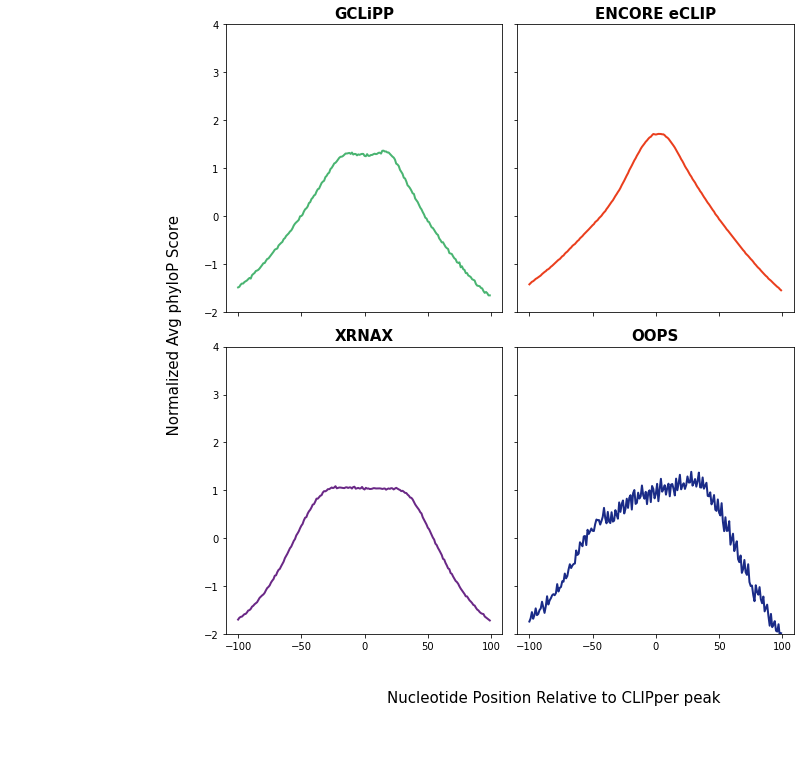

In [54]:
fig, axs = plt.subplots(2, 2, figsize=(9,10), sharex=True, sharey=True)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p100[:200]),label="phyloP100way",c=(73/255, 180/255, 113/255),linewidth=2.0)
axs[0,0].set_title('GCLiPP',fontsize=15,fontweight='bold')


axs[0,1].plot(np.arange(200)-100, normalize(eclip_p100[:200]),label="phyloP100way",c=(234/255, 62/255, 29/255),linewidth=2.0)
axs[0,1].set_title('ENCORE eCLIP',fontsize=15,fontweight='bold')



axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p100[:200]),label="phyloP100way",c=(106/255, 40/255, 134/255),linewidth=2.0)
axs[1,0].set_title('XRNAX',fontsize=15,fontweight='bold')



axs[1,1].plot(np.arange(200)-100, normalize(oops_p100[:200]),label="phyloP100way",c=(26/255, 43/255, 135/255),linewidth=2.0)
axs[1,1].set_title('OOPS',fontsize=15,fontweight='bold')
axs[1,1].set_ylim(-2,4)



axs[1,0].set_ylabel((" "*70)+'Normalized Avg phyloP Score\n',fontsize=15)
axs[1,0].set_xlabel('\n\n'+(" "*80)+'Nucleotide Position Relative to CLIPper peak',fontsize=15)
plt.xticks([-100,-50,0,50,100])

plt.tight_layout()
plt.savefig('Plot-v1.pdf')

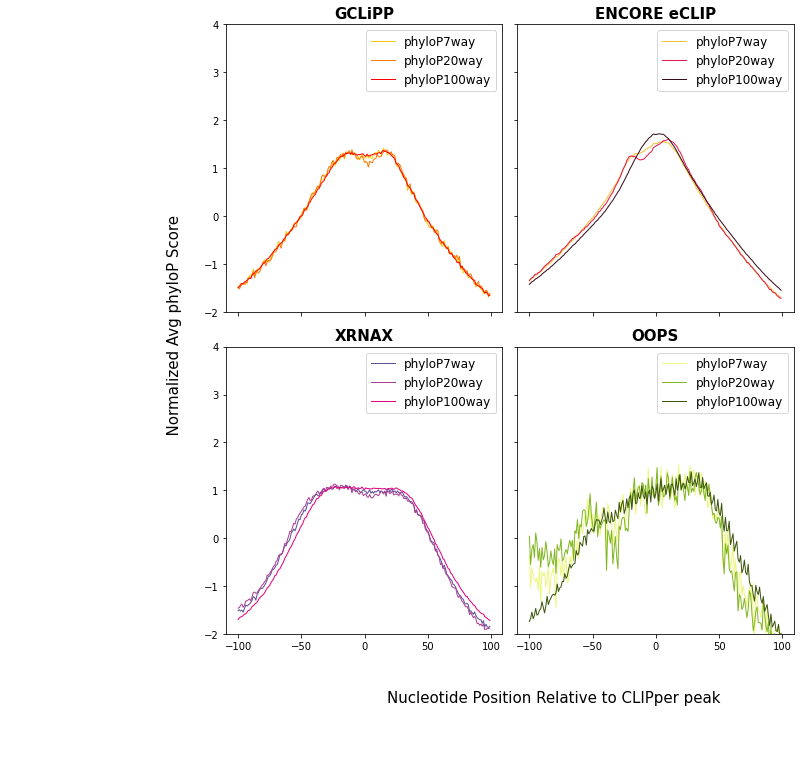

In [53]:
fig, axs = plt.subplots(2, 2, figsize=(9,10),sharex=True, sharey=True)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p7[:200]),label="phyloP7way",c='#f9c706',linewidth=1.0)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p20[:200]),label="phyloP20way",c='#fa7b03',linewidth=1.0)
axs[0,0].plot(np.arange(200)-100, normalize(gclipp_p100[:200]),label="phyloP100way",c='#ff0101',linewidth=1.0)
axs[0,0].set_title('GCLiPP',fontsize=15,fontweight='bold')
axs[0,0].legend(fontsize=12)

axs[0,1].plot(np.arange(200)-100, normalize(eclip_p7[:200]),label="phyloP7way",c='#f1c232',linewidth=1.0)
axs[0,1].plot(np.arange(200)-100, normalize(eclip_p20[:200]),label="phyloP20way",c='#e2194b',linewidth=1.0)
axs[0,1].plot(np.arange(200)-100, normalize(eclip_p100[:200]),label="phyloP100way",c='#350d17',linewidth=1.0)
axs[0,1].set_title('ENCORE eCLIP',fontsize=15,fontweight='bold')
axs[0,1].legend(fontsize=12)


axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p7[:200]),label="phyloP7way",c='#5e4e9c',linewidth=1.0)
axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p20[:200]),label="phyloP20way",c='#ab3e8f',linewidth=1.0)
axs[1,0].plot(np.arange(200)-100, normalize(xrnax_p100[:200]),label="phyloP100way",c='#e5007d',linewidth=1.0)
axs[1,0].set_title('XRNAX',fontsize=15,fontweight='bold')
axs[1,0].legend(fontsize=12)


axs[1,1].plot(np.arange(200)-100, normalize(oops_p7[:200]),label="phyloP7way",c='#ECF87F',linewidth=1.0)
axs[1,1].plot(np.arange(200)-100, normalize(oops_p20[:200]),label="phyloP20way",c='#81B622',linewidth=1.0)
axs[1,1].plot(np.arange(200)-100, normalize(oops_p100[:200]),label="phyloP100way",c='#3D550C',linewidth=1.0)
axs[1,1].set_title('OOPS',fontsize=15,fontweight='bold')
axs[1,1].legend(fontsize=12)
axs[1,1].set_ylim(-2,4)

axs[1,0].set_ylabel((" "*70)+'Normalized Avg phyloP Score\n',fontsize=15)
axs[1,0].set_xlabel('\n\n'+(" "*80)+'Nucleotide Position Relative to CLIPper peak',fontsize=15)

plt.xticks([-100,-50,0,50,100])
plt.tight_layout()
plt.savefig('Plot-v2.pdf')